\author{Christian Amstrup Petersen}
By Christian Amstrup Petersen,
Student number: 202104742
and
Johan S. Pedersen, 
Student number: 202107518
\appendix

In [72]:
import numpy as np
import matplotlib.pyplot as plt

# Given a matrix vector in R^600, the function transforms it to a 30 x 20 matrix for plotting as a heatmap. Any supplied title will be set on the plot.
def prepareForHeatmapAndPlot(A, title = ""):
    AHeat = np.zeros((20,30))

    for h in range(600):
        xC = h % 30 
        yC = int(np.floor( h / 30 ))
        AHeat[yC][xC] = A[h]

    fig, ax = plt.subplots()
    hm = ax.matshow(AHeat, cmap='Reds')
    fig.colorbar(hm)
    ax.set_title(title)

We are given a piece of land to work with, specificly a 20 m $\times$ 30 m parking lot. We're told that the lot is illuminated by several lamps, placed around the lot, at different heights. The lot is divided into 600 squares, each measuring 1 m $\times$ 1 m. For any given square $j$, the denote the illumination level of that with $y_j$ for $j = 0,...,599$. We denote the power of light, for a given lamp $i$, by $x_i$. We can then measure the light supplied by lamp $i$, in a given square $j$, with: $x_i/d^2_{ij}$, with $d_{ij}$ denoting the distance from $i$ to the center of $j$ in $\mathbb{R}^3$. \\
From this we can contruct the following list of formulas, for use in this assignment: \\ 
The base formula:
$$y_j = \frac{x_i}{d_{i,j}^2}$$
The total amount, for any given square:
$$y_j = \frac{x_0}{d_{0,j}^2} +\dots +\frac{x_{11}}{d_{11,j}^2}$$
And the total illumination, for all squares are then:
\begin{align*}
y_0 = \frac{x_0}{d_{0,0}^2} +&\dots +\frac{x_{11}}{d_{11,0}^2}\\
&⋮\\
y_{599} = \frac{x_0}{d_{0,599}^2} +&\dots +\frac{x_{11}}{d_{11,599}^2}\\
\end{align*}



\section{The relation}


In [73]:
# Position of the lamps
x = np.array([
    (2, 3, 3.), 
    (4, 13, 3.6), 
    (4, 19, 3.), 
    (11, 5, 3.5), 
    (12, 13, 4.), 
    (13, 18, 3.6), 
    (15, 2, 4.5), 
    (16, 17, 3.), 
    (20, 4, 2.8), 
    (24, 12, 4.0), 
    (26, 16, 3.8), 
    (28, 9, 3.4)
])

A = np.empty((600,12))

for k in range(600):
    # The x-coordinate for any given squares' center
    xCor = ( k % 30 ) + 0.5
    # The y-coordinate for any given squares' center
    yCor = np.floor( k / 30 ) + 0.5
    for l in range(12):
        # Each square gets a third value of 0, as each tile is at height 0 meter
        d_ij = x[l] - np.array([xCor, yCor, 0])
        distSquared = np.vdot(d_ij, d_ij)
        A[k, l] = 1 / (distSquared)

print("Shape of A: ", A.shape)
print(A)

Shape of A:  (600, 12)
[[0.05714286 0.00551086 0.00275103 ... 0.00142755 0.00110505 0.00119039]
 [0.06451613 0.0056993  0.0027972  ... 0.00152788 0.00116967 0.00127217]
 [0.06451613 0.00583226 0.00282885 ... 0.001638   0.00123925 0.00136229]
 ...
 [0.00107354 0.0016462  0.00178094 ... 0.01183432 0.03455425 0.00819269]
 [0.00101678 0.00152565 0.00164069 ... 0.01081081 0.03035823 0.00819269]
 [0.00096386 0.00141751 0.0015163  ... 0.0097561  0.02568053 0.00806062]]


\section{Heat plot}
Wanting to visualize the data, we setup a heatplot of the parking plot, with the light-level of each lamp set to 20.0:

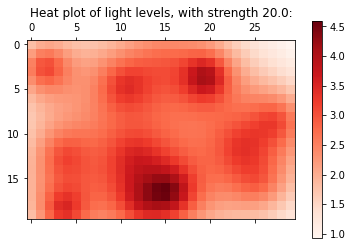

In [74]:
xi = np.empty((12, 1))
# Light levels set to 20
xi.fill(20)

prepareForHeatmapAndPlot(A @ xi, "Heat plot of light levels, with strength 20.0:") 

\section{The smallest squares}
As we don't want to waste unnessecary energy, lighting the squares to a point too much, we set our sights on an 'optimal' solution, which a light-level as close to 1.0 as possible in all the squares. We want to calculate this, using firstly QR-decomposition (via an improved Gram-Schmidt). We here use the code seen in chapter 15.3:

In [75]:
def improved_gram_schmidt(a): 
    _, k = a.shape
    q = np.copy(a)
    r = np.zeros((k, k)) 
    for i in range(k):
        r[i, i] = np.linalg.norm(q[:, i])
        q[:, i] /= r[i,i]
        r[[i], i+1:] = q[:, [i]].T @ q[:, i+1:]
        q[:, i+1:] -= q[:, [i]] @ r[[i], i+1:]
    return q, r

def back_subs(r, c): 
    n, _ = r.shape
    x = np.empty((n, 1))
    for i in reversed(range(n)):
        x[i] = (c[i] - r[[i], i+1:] @ x[i+1:]) / r[i, i] 
    return x

# Our optimal solution of y_i = 1
b = np.ones((600, 1))

q, r = improved_gram_schmidt(A)
x_qr_fgs = back_subs(r, q.T @ b)

print("Estimated lightlevels, using QR-decomposition: \n", x_qr_fgs)

Estimated lightlevels, using QR-decomposition: 
 [[ 9.60745799]
 [ 9.70985021]
 [ 6.66057705]
 [ 5.89838105]
 [ 5.43362216]
 [ 4.33070806]
 [11.03932138]
 [ 4.71068834]
 [ 5.79790553]
 [ 2.50817097]
 [12.37719594]
 [10.19220549]]


And now using SVD-decomposition, as seen in formula 16.5:

In [76]:
u, s, vt = np.linalg.svd(A, full_matrices=False)

sigma_inv = np.diag(1/s)

svd_x = vt.T @ sigma_inv @ u.T @ b

print("Estimated light-levels, using SVD-decomposition: \n", svd_x)


Estimated light-levels, using SVD-decomposition: 
 [[ 9.60745799]
 [ 9.70985021]
 [ 6.66057705]
 [ 5.89838105]
 [ 5.43362216]
 [ 4.33070806]
 [11.03932138]
 [ 4.71068834]
 [ 5.79790553]
 [ 2.50817097]
 [12.37719594]
 [10.19220549]]


\section{Heat plot 2: Electric boogaloo}
To reuse our strategy of visualizing data, we turn our heads back to heatmaps. Now we would like to show how succesfull we were in optimizing our light-levels. In our minds, the best way to represent this, is the absolute difference, so:
$$ \{z_i \in B_{dif} ~| ~~|y_i -1.0|~~ \} $$

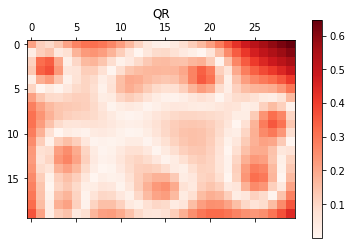

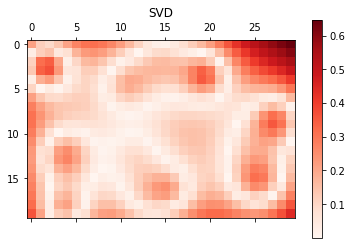

In [77]:
b_QR_dif = np.abs(( A @ x_qr_fgs ) - b)
b_SVD_dif = np.abs(( A @ svd_x ) - b)

prepareForHeatmapAndPlot(b_QR_dif, "QR")
prepareForHeatmapAndPlot(b_SVD_dif, "SVD")

# The higher grade red, the bigger the difference from the wanted amount of light 


In [78]:
# Using numpy.max we get the biggest difference between any y_i and 1.0. 
print("Max difference, using QR: ", np.max(b_QR_dif))
print("Max difference, using SVD: ", np.max(b_SVD_dif))

Max difference, using QR:  0.6456414557075378
Max difference, using SVD:  0.6456414557075382


In [79]:
# Biggest difference in methods:
b_QR_sum = np.sum(b_QR_dif)
b_SVD_sum = np.sum(b_SVD_dif)

print(np.sum(np.abs(b_QR_dif - b_SVD_dif)))
print(b_QR_sum)
print(b_SVD_sum)

6.766809335090329e-13
82.87128492903479
82.8712849290348


\section{Kappa, cos and eta}
We want now to calculate $\kappa(A)$, cos $\theta$ and $\eta$. Using the notes from chapter 17, we can derive the following:

$\kappa(a)$:

In [80]:
A_cond = s[0] / s[11]
print(A_cond)

8.058798048103753


cos $\theta$:

In [81]:
proj_b = A @ x_qr_fgs # Projection of b
cos_theta = np.linalg.norm(proj_b) / np.linalg.norm(b)
print(np.arccos(cos_theta) * 180 / np.pi)

10.303454367711492


$\eta$:

In [82]:
x = vt.T @ (np.diag(1/s) @ (u.T @ b))
eta = s[0] * np.linalg.norm(x) / np.linalg.norm(proj_b)
print(f'{eta:e}')

1.147550e+00


Using the formula 17.3, we get the upper bound for the conditional number, in relation to how changes in $A$, affects our $x$ (Using our QR-based $x$ as it produced the least amount a deviation from the wanted amount):

In [83]:
A_cond_largest = (A_cond + (A_cond**2 * np.sqrt(1-cos_theta**2) / (eta * cos_theta)))
print(f'{A_cond_largest:e}')

1.834716e+01


If we let $x_0 = 9.60745799$, as seen in assignment $b$, we can conclude, that with our calculations, we will get results within: 
$x_0 \times 10^1 \times \epsilon_{machine} \approx 10^{-14}$ of the correct solution:

In [85]:
9.60745799 * 10 * np.finfo(float).eps

2.1332842137233855e-14